In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


# Addition 
- A + B

## Parameters Config
- Total data size: 80000
- Maximum data: 999
- Minimum data: 0
- Maximum result: 1998
- Minomum result: 0

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows): # ex: (C=43+7, num_rows=MAXLEN) or (C=50, num_rows=DIGITS + 1)
        x = np.zeros((num_rows, len(self.chars))) 
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [9]:
ctable.char_indices

{' ': 0,
 '+': 1,
 '0': 2,
 '1': 3,
 '2': 4,
 '3': 5,
 '4': 6,
 '5': 7,
 '6': 8,
 '7': 9,
 '8': 10,
 '9': 11}

## Data Generation

In [6]:
questions = []
expected = []
seen = set()      # 用來確保資料不會重複
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    # f 是一個產生 1-3 位數亂數的 function
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen: 
        continue
    seen.add(key)
    q = '{}+{}'.format(a, b) # 並沒有說小的數字放前面 大的數字放後面
    query = q + ' ' * (MAXLEN - len(q)) # 確保 input 長度一樣
    ans = str(a + b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1] # [::-1] 會讓 query 相反過來，例如 "43+7   " 變成 "   7+34"，這個寫法我都不知道
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [7]:
print(questions[:5], expected[:5])

['368+847', '834+92 ', '69+3   ', '16+82  ', '10+156 '] ['1215', '926 ', '72  ', '98  ', '166 ']


## Processing

In [8]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool) 
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN) # 取每一筆 sentence 的意思，每一筆 sentence 是用 7 * 12 的矩陣表示
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [9]:
indices = np.arange(len(y))
np.random.shuffle(indices) # 原來把資料弄亂還可以這樣寫
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    # 20000
train_y = y[:20000]
test_x = x[20000:]     # 60000
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Validation Data:
(2000, 7, 12)
(2000, 4, 12)
Testing Data:
(60000, 7, 12)
(60000, 4, 12)


In [10]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False False False False  True False False
   False]
  [False False False False False False False False  True False False
   False]
  [False False False False False False False False False False  True
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False  True False False False False False False
   False]
  [False False False False False False  True False False False False
   False]
  [ True False False False False False False False False False False
   False]]

 [[False False False False False False  True False False False False
   False]
  [False False False False False False  True False False False False
   False]
  [False False False False False False False False  True False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False  True False False False
   False]
  [False False False False False False Fal

## Build Model

In [50]:
print('Build model...')

############################################
##### Build your own model here ############
############################################
model = Sequential()
# model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)),return_sequences=True))
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
# model.add(layers.Lambda(lambda x: x[:,-(DIGITS + 1):,:]))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.save('original_model.h5') 

## Training

In [51]:
originList = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 0
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 238us/step - loss: 2.0320 - acc: 0.2833 - val_loss: 1.8649 - val_acc: 0.3224
Q 34+486  T 520  ☒ 133 
Q 17+471  T 488  ☒ 133 
Q 557+844 T 1401 ☒ 113 
Q 19+326  T 345  ☒ 133 
Q 604+6   T 610  ☒ 13  
Q 355+284 T 639  ☒ 133 
Q 759+224 T 983  ☒ 113 
Q 196+994 T 1190 ☒ 1131
Q 780+810 T 1590 ☒ 113 
Q 903+128 T 1031 ☒ 113 

--------------------------------------------------
Iteration 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 116us/step - loss: 1.8534 - acc: 0.3313 - val_loss: 1.8257 - val_acc: 0.3369
Q 252+10  T 262  ☒ 222 
Q 803+40  T 843  ☒ 102 
Q 70+495  T 565  ☒ 102 
Q 99+33   T 132  ☒ 102 
Q 69+132  T 201  ☒ 102 
Q 984+403 T 1387 ☒ 1012
Q 26+236  T 262  ☒ 142 
Q 503+22  T 525  ☒ 102 
Q 379+952 T 1331 ☒ 1112
Q 939+513 T 1452 ☒ 1012

-------------------

18000/18000 [==============================] - 2s 125us/step - loss: 1.1938 - acc: 0.5543 - val_loss: 1.2104 - val_acc: 0.5388
Q 71+54   T 125  ☒ 127 
Q 336+874 T 1210 ☒ 1218
Q 320+481 T 801  ☒ 822 
Q 733+801 T 1534 ☒ 1448
Q 100+261 T 361  ☒ 114 
Q 96+43   T 139  ☒ 131 
Q 64+375  T 439  ☒ 444 
Q 571+935 T 1506 ☒ 1438
Q 82+776  T 858  ☒ 757 
Q 759+224 T 983  ☒ 990 

--------------------------------------------------
Iteration 15
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 1.1597 - acc: 0.5684 - val_loss: 1.1415 - val_acc: 0.5741
Q 79+34   T 113  ☒ 132 
Q 584+666 T 1250 ☒ 1233
Q 544+72  T 616  ☒ 618 
Q 38+80   T 118  ☒ 111 
Q 528+71  T 599  ☒ 614 
Q 768+623 T 1391 ☒ 1403
Q 410+488 T 898  ☒ 941 
Q 998+666 T 1664 ☒ 1644
Q 17+58   T 75   ☒ 10  
Q 443+88  T 531  ☒ 521 

--------------------------------------------------
Iteration 16
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 118us/step - loss: 0.7170 - acc: 0.7405 - val_loss: 0.7426 - val_acc: 0.7211
Q 713+849 T 1562 ☒ 1668
Q 7+808   T 815  ☒ 818 
Q 83+368  T 451  ☑ 451 
Q 857+44  T 901  ☑ 901 
Q 296+993 T 1289 ☒ 1282
Q 719+964 T 1683 ☒ 1690
Q 86+233  T 319  ☒ 320 
Q 51+980  T 1031 ☑ 1031
Q 944+83  T 1027 ☒ 1025
Q 207+50  T 257  ☒ 268 

--------------------------------------------------
Iteration 29
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 0.6723 - acc: 0.7564 - val_loss: 0.6999 - val_acc: 0.7378
Q 463+30  T 493  ☒ 495 
Q 61+569  T 630  ☒ 631 
Q 41+580  T 621  ☒ 623 
Q 84+419  T 503  ☒ 502 
Q 303+634 T 937  ☒ 955 
Q 236+67  T 303  ☒ 302 
Q 786+72  T 858  ☑ 858 
Q 86+67   T 153  ☒ 154 
Q 604+21  T 625  ☒ 631 
Q 706+541 T 1247 ☒ 1335

--------------------------------------------------
Iteration 30
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 118us/step - loss: 0.2049 - acc: 0.9505 - val_loss: 0.2238 - val_acc: 0.9329
Q 538+266 T 804  ☑ 804 
Q 55+17   T 72   ☑ 72  
Q 184+334 T 518  ☑ 518 
Q 439+15  T 454  ☑ 454 
Q 667+27  T 694  ☑ 694 
Q 69+235  T 304  ☑ 304 
Q 74+466  T 540  ☑ 540 
Q 77+755  T 832  ☑ 832 
Q 363+765 T 1128 ☑ 1128
Q 9+675   T 684  ☒ 694 

--------------------------------------------------
Iteration 43
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 114us/step - loss: 0.1710 - acc: 0.9658 - val_loss: 0.2102 - val_acc: 0.9383
Q 987+448 T 1435 ☑ 1435
Q 987+448 T 1435 ☑ 1435
Q 418+56  T 474  ☑ 474 
Q 905+329 T 1234 ☒ 1244
Q 965+213 T 1178 ☑ 1178
Q 882+259 T 1141 ☑ 1141
Q 59+654  T 713  ☑ 713 
Q 526+773 T 1299 ☒ 1399
Q 54+776  T 830  ☑ 830 
Q 224+734 T 958  ☒ 968 

--------------------------------------------------
Iteration 44
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 119us/step - loss: 0.0763 - acc: 0.9850 - val_loss: 0.1158 - val_acc: 0.9640
Q 226+91  T 317  ☑ 317 
Q 108+9   T 117  ☑ 117 
Q 81+231  T 312  ☑ 312 
Q 337+42  T 379  ☒ 389 
Q 955+60  T 1015 ☑ 1015
Q 878+924 T 1802 ☒ 1812
Q 74+67   T 141  ☑ 141 
Q 840+189 T 1029 ☑ 1029
Q 117+957 T 1074 ☑ 1074
Q 65+527  T 592  ☑ 592 

--------------------------------------------------
Iteration 57
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 117us/step - loss: 0.0984 - acc: 0.9747 - val_loss: 0.1253 - val_acc: 0.9588
Q 39+836  T 875  ☑ 875 
Q 599+48  T 647  ☑ 647 
Q 707+492 T 1199 ☑ 1199
Q 48+932  T 980  ☑ 980 
Q 595+778 T 1373 ☑ 1373
Q 54+12   T 66   ☑ 66  
Q 25+65   T 90   ☑ 90  
Q 587+78  T 665  ☑ 665 
Q 470+1   T 471  ☑ 471 
Q 79+975  T 1054 ☑ 1054

--------------------------------------------------
Iteration 58
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 117us/step - loss: 0.0257 - acc: 0.9973 - val_loss: 0.0645 - val_acc: 0.9793
Q 371+358 T 729  ☑ 729 
Q 9+889   T 898  ☒ 888 
Q 538+733 T 1271 ☑ 1271
Q 666+429 T 1095 ☑ 1095
Q 851+558 T 1409 ☑ 1409
Q 641+106 T 747  ☑ 747 
Q 154+107 T 261  ☑ 261 
Q 816+21  T 837  ☑ 837 
Q 264+84  T 348  ☑ 348 
Q 45+458  T 503  ☑ 503 

--------------------------------------------------
Iteration 71
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 115us/step - loss: 0.0680 - acc: 0.9805 - val_loss: 0.1786 - val_acc: 0.9341
Q 35+449  T 484  ☑ 484 
Q 99+153  T 252  ☑ 252 
Q 76+892  T 968  ☑ 968 
Q 354+647 T 1001 ☒ 1011
Q 783+85  T 868  ☑ 868 
Q 850+94  T 944  ☒ 943 
Q 291+121 T 412  ☑ 412 
Q 803+40  T 843  ☑ 843 
Q 28+401  T 429  ☑ 429 
Q 997+130 T 1127 ☒ 1117

--------------------------------------------------
Iteration 72
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 118us/step - loss: 0.0139 - acc: 0.9990 - val_loss: 0.0468 - val_acc: 0.9851
Q 85+11   T 96   ☑ 96  
Q 158+47  T 205  ☑ 205 
Q 479+0   T 479  ☑ 479 
Q 20+79   T 99   ☒ 90  
Q 902+6   T 908  ☑ 908 
Q 66+988  T 1054 ☑ 1054
Q 624+43  T 667  ☑ 667 
Q 19+608  T 627  ☑ 627 
Q 320+846 T 1166 ☑ 1166
Q 867+144 T 1011 ☑ 1011

--------------------------------------------------
Iteration 85
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 0.0108 - acc: 0.9996 - val_loss: 0.0448 - val_acc: 0.9835
Q 720+96  T 816  ☑ 816 
Q 185+42  T 227  ☑ 227 
Q 279+287 T 566  ☑ 566 
Q 204+9   T 213  ☑ 213 
Q 9+736   T 745  ☑ 745 
Q 140+79  T 219  ☑ 219 
Q 929+87  T 1016 ☑ 1016
Q 23+671  T 694  ☑ 694 
Q 970+878 T 1848 ☒ 1847
Q 88+646  T 734  ☑ 734 

--------------------------------------------------
Iteration 86
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 134us/step - loss: 0.0063 - acc: 0.9999 - val_loss: 0.0357 - val_acc: 0.9878
Q 441+454 T 895  ☑ 895 
Q 433+26  T 459  ☑ 459 
Q 78+971  T 1049 ☑ 1049
Q 279+330 T 609  ☒ 509 
Q 58+636  T 694  ☑ 694 
Q 713+849 T 1562 ☑ 1562
Q 385+201 T 586  ☑ 586 
Q 55+791  T 846  ☑ 846 
Q 112+8   T 120  ☑ 120 
Q 783+42  T 825  ☑ 825 

--------------------------------------------------
Iteration 99
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 132us/step - loss: 0.0059 - acc: 0.9999 - val_loss: 0.0347 - val_acc: 0.9883
Q 25+624  T 649  ☑ 649 
Q 78+335  T 413  ☑ 413 
Q 687+13  T 700  ☒ 600 
Q 728+560 T 1288 ☑ 1288
Q 497+648 T 1145 ☑ 1145
Q 183+74  T 257  ☑ 257 
Q 765+31  T 796  ☑ 796 
Q 921+50  T 971  ☑ 971 
Q 31+96   T 127  ☑ 127 
Q 110+85  T 195  ☑ 195 

--------------------------------------------------
Iteration 100
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [====

18000/18000 [==============================] - 2s 111us/step - loss: 0.0042 - acc: 0.9999 - val_loss: 0.0341 - val_acc: 0.9886
Q 849+255 T 1104 ☑ 1104
Q 48+816  T 864  ☑ 864 
Q 51+734  T 785  ☑ 785 
Q 901+713 T 1614 ☑ 1614
Q 271+411 T 682  ☑ 682 
Q 903+574 T 1477 ☑ 1477
Q 337+42  T 379  ☑ 379 
Q 157+340 T 497  ☒ 597 
Q 644+366 T 1010 ☒ 1000
Q 117+957 T 1074 ☑ 1074

--------------------------------------------------
Iteration 113
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 113us/step - loss: 0.0042 - acc: 0.9999 - val_loss: 0.0347 - val_acc: 0.9884
Q 90+586  T 676  ☑ 676 
Q 437+88  T 525  ☑ 525 
Q 93+914  T 1007 ☑ 1007
Q 73+576  T 649  ☑ 649 
Q 777+3   T 780  ☑ 780 
Q 17+30   T 47   ☑ 47  
Q 397+953 T 1350 ☑ 1350
Q 398+9   T 407  ☑ 407 
Q 474+75  T 549  ☑ 549 
Q 739+279 T 1018 ☑ 1018

--------------------------------------------------
Iteration 114
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 122us/step - loss: 0.0033 - acc: 0.9999 - val_loss: 0.0348 - val_acc: 0.9875
Q 294+460 T 754  ☑ 754 
Q 81+73   T 154  ☑ 154 
Q 37+374  T 411  ☑ 411 
Q 621+22  T 643  ☑ 643 
Q 43+40   T 83   ☑ 83  
Q 145+10  T 155  ☑ 155 
Q 10+160  T 170  ☑ 170 
Q 814+416 T 1230 ☑ 1230
Q 72+434  T 506  ☑ 506 
Q 110+654 T 764  ☑ 764 

--------------------------------------------------
Iteration 127
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 119us/step - loss: 0.0038 - acc: 0.9997 - val_loss: 0.0341 - val_acc: 0.9891
Q 34+796  T 830  ☑ 830 
Q 537+49  T 586  ☑ 586 
Q 16+425  T 441  ☑ 441 
Q 43+516  T 559  ☑ 559 
Q 413+815 T 1228 ☑ 1228
Q 4+598   T 602  ☑ 602 
Q 813+7   T 820  ☑ 820 
Q 159+91  T 250  ☑ 250 
Q 639+727 T 1366 ☑ 1366
Q 734+558 T 1292 ☑ 1292

--------------------------------------------------
Iteration 128
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 119us/step - loss: 0.0022 - acc: 0.9999 - val_loss: 0.0343 - val_acc: 0.9878
Q 987+448 T 1435 ☑ 1435
Q 145+10  T 155  ☑ 155 
Q 86+67   T 153  ☑ 153 
Q 55+156  T 211  ☑ 211 
Q 4+182   T 186  ☑ 186 
Q 493+988 T 1481 ☑ 1481
Q 739+279 T 1018 ☒ 1008
Q 42+709  T 751  ☑ 751 
Q 88+269  T 357  ☑ 357 
Q 202+497 T 699  ☑ 699 

--------------------------------------------------
Iteration 141
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 119us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0322 - val_acc: 0.9880
Q 4+231   T 235  ☑ 235 
Q 74+263  T 337  ☑ 337 
Q 52+365  T 417  ☑ 417 
Q 377+861 T 1238 ☑ 1238
Q 79+551  T 630  ☑ 630 
Q 598+993 T 1591 ☑ 1591
Q 239+16  T 255  ☑ 255 
Q 35+915  T 950  ☑ 950 
Q 759+224 T 983  ☑ 983 
Q 67+244  T 311  ☑ 311 

--------------------------------------------------
Iteration 142
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 120us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 0.9890
Q 682+781 T 1463 ☑ 1463
Q 66+379  T 445  ☑ 445 
Q 816+28  T 844  ☑ 844 
Q 44+328  T 372  ☑ 372 
Q 36+591  T 627  ☑ 627 
Q 46+150  T 196  ☑ 196 
Q 9+888   T 897  ☒ 887 
Q 589+86  T 675  ☑ 675 
Q 636+587 T 1223 ☑ 1223
Q 48+429  T 477  ☑ 477 

--------------------------------------------------
Iteration 155
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0308 - val_acc: 0.9885
Q 965+763 T 1728 ☑ 1728
Q 6+666   T 672  ☑ 672 
Q 484+717 T 1201 ☑ 1201
Q 362+18  T 380  ☑ 380 
Q 433+710 T 1143 ☑ 1143
Q 406+73  T 479  ☒ 489 
Q 5+941   T 946  ☑ 946 
Q 177+219 T 396  ☑ 396 
Q 623+39  T 662  ☑ 662 
Q 789+10  T 799  ☑ 799 

--------------------------------------------------
Iteration 156
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 123us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9896
Q 0+147   T 147  ☑ 147 
Q 22+971  T 993  ☑ 993 
Q 160+95  T 255  ☑ 255 
Q 982+403 T 1385 ☑ 1385
Q 382+580 T 962  ☑ 962 
Q 45+24   T 69   ☑ 69  
Q 81+231  T 312  ☑ 312 
Q 810+10  T 820  ☑ 820 
Q 96+43   T 139  ☑ 139 
Q 150+179 T 329  ☑ 329 

--------------------------------------------------
Iteration 169
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 120us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0292 - val_acc: 0.9898
Q 595+357 T 952  ☑ 952 
Q 210+503 T 713  ☑ 713 
Q 45+659  T 704  ☑ 704 
Q 86+758  T 844  ☑ 844 
Q 965+213 T 1178 ☑ 1178
Q 540+26  T 566  ☑ 566 
Q 292+716 T 1008 ☒ 1007
Q 922+547 T 1469 ☑ 1469
Q 540+81  T 621  ☑ 621 
Q 637+675 T 1312 ☑ 1312

--------------------------------------------------
Iteration 170
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 121us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9892
Q 144+65  T 209  ☑ 209 
Q 276+95  T 371  ☑ 371 
Q 63+761  T 824  ☑ 824 
Q 77+253  T 330  ☑ 330 
Q 79+650  T 729  ☑ 729 
Q 93+780  T 873  ☑ 873 
Q 332+419 T 751  ☑ 751 
Q 242+57  T 299  ☑ 299 
Q 141+497 T 638  ☑ 638 
Q 160+95  T 255  ☑ 255 

--------------------------------------------------
Iteration 183
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0305 - val_acc: 0.9881
Q 281+30  T 311  ☑ 311 
Q 199+177 T 376  ☑ 376 
Q 895+5   T 900  ☒ 890 
Q 144+65  T 209  ☑ 209 
Q 18+207  T 225  ☑ 225 
Q 219+303 T 522  ☑ 522 
Q 69+744  T 813  ☑ 813 
Q 37+972  T 1009 ☑ 1009
Q 637+775 T 1412 ☑ 1412
Q 29+60   T 89   ☑ 89  

--------------------------------------------------
Iteration 184
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 130us/step - loss: 9.3101e-04 - acc: 1.0000 - val_loss: 0.0292 - val_acc: 0.9888
Q 390+825 T 1215 ☑ 1215
Q 878+12  T 890  ☑ 890 
Q 102+46  T 148  ☑ 148 
Q 3+814   T 817  ☑ 817 
Q 592+74  T 666  ☑ 666 
Q 81+231  T 312  ☑ 312 
Q 485+95  T 580  ☑ 580 
Q 14+639  T 653  ☑ 653 
Q 58+199  T 257  ☑ 257 
Q 80+800  T 880  ☑ 880 

--------------------------------------------------
Iteration 197
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 132us/step - loss: 8.6073e-04 - acc: 1.0000 - val_loss: 0.0297 - val_acc: 0.9890
Q 991+58  T 1049 ☑ 1049
Q 68+72   T 140  ☑ 140 
Q 63+326  T 389  ☑ 389 
Q 23+540  T 563  ☑ 563 
Q 36+591  T 627  ☑ 627 
Q 721+17  T 738  ☑ 738 
Q 965+763 T 1728 ☑ 1728
Q 43+366  T 409  ☑ 409 
Q 762+82  T 844  ☑ 844 
Q 671+45  T 716  ☑ 716 

--------------------------------------------------
Iteration 198
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18

## Testing

In [53]:
print("MSG : Prediction") 
loss, acc = model.evaluate(test_x,test_y)
print("Loss:",loss)
print("Accuracy:",acc)

MSG : Prediction
60000/60000 [==============================] - 4s 72us/step
Loss: 0.03193951640563707
Accuracy: 0.9897208333333334


In [54]:
originList

[0.322375,
 0.33687499952316285,
 0.3416250002384186,
 0.35387500023841856,
 0.36887500047683713,
 0.39849999952316284,
 0.41287499952316287,
 0.44350000047683713,
 0.4468750002384186,
 0.47337500047683717,
 0.494875,
 0.5018750004768372,
 0.5268749990463257,
 0.5428749995231629,
 0.5387500009536743,
 0.5741249995231629,
 0.5767500004768371,
 0.5943749995231629,
 0.602125,
 0.61775,
 0.6209999995231629,
 0.6375000009536743,
 0.6412500009536743,
 0.6557499990463257,
 0.6557499990463257,
 0.6762499990463257,
 0.6933750004768372,
 0.7002499990463257,
 0.721125,
 0.7377500009536743,
 0.7603750009536743,
 0.776,
 0.7976250004768372,
 0.8291250004768371,
 0.8096249990463257,
 0.8696249995231629,
 0.8860000009536744,
 0.894,
 0.901625,
 0.9181250004768372,
 0.9122500004768371,
 0.9282500004768371,
 0.9328750009536744,
 0.9382500009536743,
 0.93425,
 0.9486249995231628,
 0.9450000004768372,
 0.9553749995231628,
 0.9437500009536743,
 0.9492499990463257,
 0.960375,
 0.96225,
 0.9647499995231629,

In [24]:
model.metrics_names

['loss', 'acc']

# Subtraction 
- (A - B, A ≥ B)

## Parameters Config
- Total data size: 80000
- Maximum data: 999
- Minimum data: 0
- Maximum result: 999
- Minomum result: 0

In [57]:
chars_sub = '0123456789- '

In [58]:
ctable_sub = CharacterTable(chars_sub)

## Data Generation

In [63]:
questions_sub = []
expected_sub = []
seen_sub = set()      
print('Generating data...')
while len(questions_sub) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    a, b = max(a,b),min(a,b)
    key = tuple((a, b))
    if key in seen: 
        continue
    seen.add(key)
    q = '{}-{}'.format(a,b) # 大減小
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a - b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions_sub.append(query)
    expected_sub.append(ans)
print('Total addition questions:', len(questions_sub))

Generating data...
Total addition questions: 80000


In [66]:
print(questions_sub[5:10], expected_sub[5:10])

['700-599', '888-879', '501-300', '196-134', '813-698'] ['101 ', '9   ', '201 ', '62  ', '115 ']


## Process

In [67]:
print('Vectorization...')
x = np.zeros((len(questions_sub), MAXLEN, len(chars_sub)), dtype=np.bool) 
y = np.zeros((len(expected_sub), DIGITS + 1, len(chars_sub)), dtype=np.bool)
for i, sentence in enumerate(questions_sub):
    x[i] = ctable_sub.encode(sentence, MAXLEN) 
for i, sentence in enumerate(expected_sub):
    y[i] = ctable_sub.encode(sentence, DIGITS + 1)

Vectorization...


In [68]:
indices = np.arange(len(y))
np.random.shuffle(indices) 
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    
train_y = y[:20000]
test_x = x[20000:]     
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Validation Data:
(2000, 7, 12)
(2000, 4, 12)
Testing Data:
(60000, 7, 12)
(60000, 4, 12)


## Build model

In [70]:
print('Build model...')

model_sub = Sequential()
# model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)),return_sequences=True))
model_sub.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars_sub))))
model_sub.add(layers.RepeatVector(DIGITS + 1))
# model.add(layers.Lambda(lambda x: x[:,-(DIGITS + 1):,:]))
for _ in range(LAYERS):
    model_sub.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_sub.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_sub.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model_sub.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


## training

In [72]:
originList_sub = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model_sub.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList_sub.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_sub.predict_classes(rowx, verbose=0)
        q = ctable_sub.decode(rowx[0])
        correct = ctable_sub.decode(rowy[0])
        guess = ctable_sub.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 0
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 248us/step - loss: 1.8680 - acc: 0.3443 - val_loss: 1.7060 - val_acc: 0.3711
Q 593-454 T 139  ☒ 22  
Q 964-641 T 323  ☒ 22  
Q 795-599 T 196  ☒ 22  
Q 644-512 T 132  ☒ 22  
Q 710-330 T 380  ☒ 22  
Q 713-502 T 211  ☒ 22  
Q 913-369 T 544  ☒ 22  
Q 605-531 T 74   ☒ 22  
Q 429-428 T 1    ☒ 22  
Q 592-439 T 153  ☒ 22  

--------------------------------------------------
Iteration 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 118us/step - loss: 1.6907 - acc: 0.3771 - val_loss: 1.6849 - val_acc: 0.3854
Q 495-257 T 238  ☒ 13  
Q 684-185 T 499  ☒ 13  
Q 764-668 T 96   ☒ 13  
Q 878-457 T 421  ☒ 13  
Q 568-385 T 183  ☒ 13  
Q 509-224 T 285  ☒ 13  
Q 485-316 T 169  ☒ 13  
Q 921-421 T 500  ☒ 17  
Q 277-136 T 141  ☒ 13  
Q 844-678 T 166  ☒ 13  

-------------------

18000/18000 [==============================] - 2s 134us/step - loss: 1.1135 - acc: 0.5838 - val_loss: 1.1176 - val_acc: 0.5780
Q 429-375 T 54   ☒ 10  
Q 258-239 T 19   ☒ 2   
Q 841-227 T 614  ☑ 614 
Q 979-414 T 565  ☒ 553 
Q 930-675 T 255  ☒ 265 
Q 953-786 T 167  ☒ 175 
Q 389-387 T 2    ☑ 2   
Q 425-134 T 291  ☒ 282 
Q 417-319 T 98   ☒ 10  
Q 652-420 T 232  ☑ 232 

--------------------------------------------------
Iteration 15
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 1.0934 - acc: 0.5899 - val_loss: 1.1524 - val_acc: 0.5564
Q 296-160 T 136  ☒ 119 
Q 592-439 T 153  ☒ 139 
Q 844-316 T 528  ☒ 529 
Q 763-482 T 281  ☒ 269 
Q 603-254 T 349  ☒ 323 
Q 995-346 T 649  ☒ 639 
Q 822-680 T 142  ☒ 121 
Q 448-370 T 78   ☒ 10  
Q 253-136 T 117  ☒ 109 
Q 919-576 T 343  ☒ 333 

--------------------------------------------------
Iteration 16
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 127us/step - loss: 0.7416 - acc: 0.7367 - val_loss: 0.7421 - val_acc: 0.7324
Q 683-452 T 231  ☒ 230 
Q 991-683 T 308  ☑ 308 
Q 819-321 T 498  ☒ 495 
Q 300-228 T 72   ☒ 77  
Q 960-173 T 787  ☒ 786 
Q 876-588 T 288  ☒ 280 
Q 744-387 T 357  ☒ 356 
Q 871-130 T 741  ☒ 744 
Q 436-164 T 272  ☒ 278 
Q 921-283 T 638  ☒ 640 

--------------------------------------------------
Iteration 29
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 0.7208 - acc: 0.7431 - val_loss: 0.7394 - val_acc: 0.7231
Q 634-242 T 392  ☒ 490 
Q 257-242 T 15   ☒ 16  
Q 357-212 T 145  ☒ 146 
Q 790-623 T 167  ☒ 177 
Q 815-705 T 110  ☒ 111 
Q 711-499 T 212  ☒ 227 
Q 987-316 T 671  ☒ 661 
Q 790-577 T 213  ☒ 210 
Q 793-138 T 655  ☒ 650 
Q 594-443 T 151  ☑ 151 

--------------------------------------------------
Iteration 30
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 125us/step - loss: 0.1854 - acc: 0.9572 - val_loss: 0.1795 - val_acc: 0.9565
Q 838-290 T 548  ☒ 549 
Q 653-552 T 101  ☑ 101 
Q 510-395 T 115  ☒ 125 
Q 472-345 T 127  ☑ 127 
Q 836-527 T 309  ☑ 309 
Q 905-148 T 757  ☑ 757 
Q 456-182 T 274  ☑ 274 
Q 989-535 T 454  ☑ 454 
Q 890-318 T 572  ☒ 562 
Q 712-363 T 349  ☑ 349 

--------------------------------------------------
Iteration 43
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 120us/step - loss: 0.1697 - acc: 0.9619 - val_loss: 0.1698 - val_acc: 0.9602
Q 840-685 T 155  ☑ 155 
Q 738-459 T 279  ☑ 279 
Q 830-134 T 696  ☑ 696 
Q 650-518 T 132  ☒ 133 
Q 532-513 T 19   ☑ 19  
Q 906-386 T 520  ☒ 510 
Q 756-404 T 352  ☑ 352 
Q 811-645 T 166  ☑ 166 
Q 844-316 T 528  ☑ 528 
Q 858-502 T 356  ☑ 356 

--------------------------------------------------
Iteration 44
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 122us/step - loss: 0.0775 - acc: 0.9829 - val_loss: 0.0768 - val_acc: 0.9862
Q 706-489 T 217  ☑ 217 
Q 926-723 T 203  ☑ 203 
Q 955-748 T 207  ☑ 207 
Q 218-151 T 67   ☑ 67  
Q 857-16  T 841  ☒ 880 
Q 939-621 T 318  ☑ 318 
Q 911-236 T 675  ☑ 675 
Q 565-327 T 238  ☑ 238 
Q 880-376 T 504  ☑ 504 
Q 878-457 T 421  ☑ 421 

--------------------------------------------------
Iteration 57
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 119us/step - loss: 0.0695 - acc: 0.9868 - val_loss: 0.0772 - val_acc: 0.9838
Q 988-511 T 477  ☑ 477 
Q 613-557 T 56   ☑ 56  
Q 324-265 T 59   ☒ 69  
Q 696-388 T 308  ☑ 308 
Q 655-136 T 519  ☑ 519 
Q 889-184 T 705  ☑ 705 
Q 708-464 T 244  ☑ 244 
Q 635-444 T 191  ☑ 191 
Q 905-148 T 757  ☑ 757 
Q 515-237 T 278  ☑ 278 

--------------------------------------------------
Iteration 58
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 120us/step - loss: 0.0422 - acc: 0.9916 - val_loss: 0.0725 - val_acc: 0.9806
Q 429-428 T 1    ☑ 1   
Q 933-315 T 618  ☑ 618 
Q 123-119 T 4    ☒ 3   
Q 750-177 T 573  ☑ 573 
Q 619-188 T 431  ☑ 431 
Q 970-797 T 173  ☑ 173 
Q 851-348 T 503  ☑ 503 
Q 406-112 T 294  ☑ 294 
Q 891-330 T 561  ☑ 561 
Q 763-671 T 92   ☑ 92  

--------------------------------------------------
Iteration 71
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 0.0499 - acc: 0.9883 - val_loss: 0.0490 - val_acc: 0.9886
Q 504-188 T 316  ☑ 316 
Q 567-353 T 214  ☑ 214 
Q 858-473 T 385  ☑ 385 
Q 436-400 T 36   ☑ 36  
Q 754-612 T 142  ☑ 142 
Q 832-457 T 375  ☑ 375 
Q 791-758 T 33   ☑ 33  
Q 331-259 T 72   ☑ 72  
Q 831-507 T 324  ☑ 324 
Q 825-245 T 580  ☑ 580 

--------------------------------------------------
Iteration 72
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 119us/step - loss: 0.0229 - acc: 0.9966 - val_loss: 0.0307 - val_acc: 0.9947
Q 556-268 T 288  ☑ 288 
Q 528-147 T 381  ☑ 381 
Q 960-349 T 611  ☑ 611 
Q 603-355 T 248  ☑ 248 
Q 909-746 T 163  ☑ 163 
Q 971-882 T 89   ☑ 89  
Q 382-109 T 273  ☑ 273 
Q 549-503 T 46   ☑ 46  
Q 710-604 T 106  ☑ 106 
Q 567-455 T 112  ☑ 112 

--------------------------------------------------
Iteration 85
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 0.0222 - acc: 0.9967 - val_loss: 0.0307 - val_acc: 0.9952
Q 485-362 T 123  ☑ 123 
Q 812-350 T 462  ☑ 462 
Q 810-679 T 131  ☑ 131 
Q 625-617 T 8    ☑ 8   
Q 707-560 T 147  ☑ 147 
Q 458-173 T 285  ☑ 285 
Q 929-677 T 252  ☑ 252 
Q 916-314 T 602  ☑ 602 
Q 819-714 T 105  ☑ 105 
Q 300-188 T 112  ☑ 112 

--------------------------------------------------
Iteration 86
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 120us/step - loss: 0.0164 - acc: 0.9973 - val_loss: 0.0320 - val_acc: 0.9935
Q 303-141 T 162  ☑ 162 
Q 900-639 T 261  ☑ 261 
Q 893-412 T 481  ☑ 481 
Q 839-360 T 479  ☑ 479 
Q 838-762 T 76   ☑ 76  
Q 912-238 T 674  ☑ 674 
Q 287-163 T 124  ☑ 124 
Q 714-383 T 331  ☑ 331 
Q 728-414 T 314  ☑ 314 
Q 813-698 T 115  ☑ 115 

--------------------------------------------------
Iteration 99
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 0.0191 - acc: 0.9963 - val_loss: 0.0376 - val_acc: 0.9908
Q 960-343 T 617  ☑ 617 
Q 881-230 T 651  ☑ 651 
Q 861-326 T 535  ☑ 535 
Q 886-462 T 424  ☑ 424 
Q 433-334 T 99   ☑ 99  
Q 429-110 T 319  ☑ 319 
Q 620-453 T 167  ☑ 167 
Q 856-101 T 755  ☑ 755 
Q 733-222 T 511  ☑ 511 
Q 724-724 T 0    ☑ 0   

--------------------------------------------------
Iteration 100
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [====

18000/18000 [==============================] - 2s 120us/step - loss: 0.0116 - acc: 0.9987 - val_loss: 0.0207 - val_acc: 0.9972
Q 918-389 T 529  ☑ 529 
Q 476-378 T 98   ☑ 98  
Q 964-641 T 323  ☑ 323 
Q 856-162 T 694  ☑ 694 
Q 408-210 T 198  ☑ 198 
Q 729-310 T 419  ☑ 419 
Q 894-446 T 448  ☑ 448 
Q 944-203 T 741  ☑ 741 
Q 618-159 T 459  ☑ 459 
Q 593-292 T 301  ☑ 301 

--------------------------------------------------
Iteration 113
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 122us/step - loss: 0.0112 - acc: 0.9987 - val_loss: 0.0210 - val_acc: 0.9971
Q 294-293 T 1    ☑ 1   
Q 394-153 T 241  ☑ 241 
Q 977-892 T 85   ☑ 85  
Q 666-577 T 89   ☑ 89  
Q 811-645 T 166  ☑ 166 
Q 536-425 T 111  ☑ 111 
Q 875-573 T 302  ☑ 302 
Q 414-306 T 108  ☑ 108 
Q 754-302 T 452  ☑ 452 
Q 433-196 T 237  ☑ 237 

--------------------------------------------------
Iteration 114
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 121us/step - loss: 0.0091 - acc: 0.9990 - val_loss: 0.0183 - val_acc: 0.9971
Q 548-161 T 387  ☑ 387 
Q 661-158 T 503  ☑ 503 
Q 806-135 T 671  ☑ 671 
Q 636-232 T 404  ☑ 404 
Q 270-137 T 133  ☑ 133 
Q 630-624 T 6    ☑ 6   
Q 332-147 T 185  ☑ 185 
Q 562-183 T 379  ☑ 379 
Q 472-345 T 127  ☑ 127 
Q 322-311 T 11   ☑ 11  

--------------------------------------------------
Iteration 127
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 119us/step - loss: 0.0359 - acc: 0.9897 - val_loss: 0.0286 - val_acc: 0.9939
Q 755-542 T 213  ☑ 213 
Q 478-289 T 189  ☑ 189 
Q 966-807 T 159  ☑ 159 
Q 961-418 T 543  ☑ 543 
Q 446-431 T 15   ☑ 15  
Q 863-281 T 582  ☑ 582 
Q 900-516 T 384  ☑ 384 
Q 827-247 T 580  ☑ 580 
Q 482-475 T 7    ☑ 7   
Q 788-695 T 93   ☑ 93  

--------------------------------------------------
Iteration 128
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 121us/step - loss: 0.0078 - acc: 0.9993 - val_loss: 0.0201 - val_acc: 0.9966
Q 532-223 T 309  ☑ 309 
Q 899-601 T 298  ☑ 298 
Q 980-424 T 556  ☑ 556 
Q 895-210 T 685  ☑ 685 
Q 854-831 T 23   ☑ 23  
Q 384-361 T 23   ☑ 23  
Q 947-780 T 167  ☑ 167 
Q 619-318 T 301  ☑ 301 
Q 860-185 T 675  ☑ 675 
Q 471-180 T 291  ☑ 291 

--------------------------------------------------
Iteration 141
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 120us/step - loss: 0.0117 - acc: 0.9977 - val_loss: 0.0218 - val_acc: 0.9953
Q 780-294 T 486  ☑ 486 
Q 459-374 T 85   ☑ 85  
Q 949-190 T 759  ☑ 759 
Q 933-525 T 408  ☑ 408 
Q 824-535 T 289  ☑ 289 
Q 260-182 T 78   ☑ 78  
Q 725-418 T 307  ☑ 307 
Q 960-349 T 611  ☑ 611 
Q 815-289 T 526  ☑ 526 
Q 431-233 T 198  ☑ 198 

--------------------------------------------------
Iteration 142
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 121us/step - loss: 0.0065 - acc: 0.9995 - val_loss: 0.0167 - val_acc: 0.9976
Q 676-327 T 349  ☑ 349 
Q 911-468 T 443  ☑ 443 
Q 370-239 T 131  ☑ 131 
Q 552-329 T 223  ☑ 223 
Q 562-285 T 277  ☑ 277 
Q 587-483 T 104  ☑ 104 
Q 350-304 T 46   ☑ 46  
Q 809-471 T 338  ☑ 338 
Q 852-673 T 179  ☑ 179 
Q 957-677 T 280  ☑ 280 

--------------------------------------------------
Iteration 155
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 120us/step - loss: 0.0268 - acc: 0.9930 - val_loss: 0.0766 - val_acc: 0.9774
Q 755-193 T 562  ☑ 562 
Q 444-173 T 271  ☑ 271 
Q 724-136 T 588  ☑ 588 
Q 682-179 T 503  ☑ 503 
Q 773-503 T 270  ☑ 270 
Q 346-289 T 57   ☑ 57  
Q 486-186 T 300  ☒ 200 
Q 858-835 T 23   ☑ 23  
Q 390-386 T 4    ☑ 4   
Q 905-148 T 757  ☑ 757 

--------------------------------------------------
Iteration 156
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 125us/step - loss: 0.0051 - acc: 0.9998 - val_loss: 0.0153 - val_acc: 0.9981
Q 388-150 T 238  ☑ 238 
Q 865-655 T 210  ☑ 210 
Q 789-743 T 46   ☑ 46  
Q 876-763 T 113  ☑ 113 
Q 493-301 T 192  ☑ 192 
Q 302-250 T 52   ☑ 52  
Q 342-187 T 155  ☑ 155 
Q 581-408 T 173  ☑ 173 
Q 921-257 T 664  ☑ 664 
Q 627-367 T 260  ☑ 260 

--------------------------------------------------
Iteration 169
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 124us/step - loss: 0.0049 - acc: 0.9998 - val_loss: 0.0147 - val_acc: 0.9982
Q 865-533 T 332  ☑ 332 
Q 883-451 T 432  ☑ 432 
Q 901-281 T 620  ☑ 620 
Q 874-171 T 703  ☑ 703 
Q 994-370 T 624  ☑ 624 
Q 841-522 T 319  ☑ 319 
Q 812-136 T 676  ☑ 676 
Q 623-290 T 333  ☑ 333 
Q 429-402 T 27   ☑ 27  
Q 788-775 T 13   ☑ 13  

--------------------------------------------------
Iteration 170
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 121us/step - loss: 0.0042 - acc: 0.9998 - val_loss: 0.0146 - val_acc: 0.9981
Q 886-487 T 399  ☑ 399 
Q 669-500 T 169  ☑ 169 
Q 953-264 T 689  ☑ 689 
Q 711-499 T 212  ☑ 212 
Q 753-256 T 497  ☑ 497 
Q 410-236 T 174  ☑ 174 
Q 753-256 T 497  ☑ 497 
Q 678-447 T 231  ☑ 231 
Q 653-541 T 112  ☑ 112 
Q 728-116 T 612  ☑ 612 

--------------------------------------------------
Iteration 183
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 0.0043 - acc: 0.9998 - val_loss: 0.0148 - val_acc: 0.9979
Q 743-298 T 445  ☑ 445 
Q 495-417 T 78   ☑ 78  
Q 889-108 T 781  ☑ 781 
Q 876-169 T 707  ☑ 707 
Q 914-609 T 305  ☑ 305 
Q 699-234 T 465  ☑ 465 
Q 600-438 T 162  ☑ 162 
Q 666-577 T 89   ☑ 89  
Q 711-415 T 296  ☑ 296 
Q 317-232 T 85   ☑ 85  

--------------------------------------------------
Iteration 184
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 122us/step - loss: 0.0038 - acc: 0.9999 - val_loss: 0.0134 - val_acc: 0.9981
Q 673-529 T 144  ☑ 144 
Q 456-415 T 41   ☑ 41  
Q 930-803 T 127  ☑ 127 
Q 843-402 T 441  ☑ 441 
Q 812-495 T 317  ☑ 317 
Q 267-128 T 139  ☑ 139 
Q 908-577 T 331  ☑ 331 
Q 691-488 T 203  ☑ 203 
Q 881-230 T 651  ☑ 651 
Q 674-296 T 378  ☑ 378 

--------------------------------------------------
Iteration 197
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 122us/step - loss: 0.0038 - acc: 0.9999 - val_loss: 0.0134 - val_acc: 0.9984
Q 778-719 T 59   ☑ 59  
Q 473-377 T 96   ☑ 96  
Q 939-621 T 318  ☑ 318 
Q 909-382 T 527  ☑ 527 
Q 200-137 T 63   ☑ 63  
Q 634-141 T 493  ☑ 493 
Q 688-412 T 276  ☑ 276 
Q 531-205 T 326  ☑ 326 
Q 461-232 T 229  ☑ 229 
Q 909-382 T 527  ☑ 527 

--------------------------------------------------
Iteration 198
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

In [73]:
model_sub.save('original_model_sub.h5') 

## Testing

In [74]:
print("MSG : Prediction") 
loss, acc = model_sub.evaluate(test_x,test_y)
print("Loss:",loss)
print("Accuracy:",acc)

MSG : Prediction
60000/60000 [==============================] - 4s 74us/step
Loss: 0.02964235748577242
Accuracy: 0.9942666666666666


In [75]:
originList_sub

[0.3711250002384186,
 0.385375,
 0.38812500023841856,
 0.4009999997615814,
 0.41737500023841856,
 0.44675,
 0.4695000002384186,
 0.5213750004768372,
 0.525125,
 0.54325,
 0.5477499990463257,
 0.5694999995231629,
 0.5807499990463257,
 0.5791250004768371,
 0.5780000009536743,
 0.5563750009536743,
 0.6163750009536744,
 0.607875,
 0.6030000004768371,
 0.6712499995231629,
 0.6787500004768372,
 0.6799999990463257,
 0.6906249990463257,
 0.6951249995231629,
 0.7127500009536744,
 0.7156250009536743,
 0.7296249990463257,
 0.7326250009536743,
 0.7323750004768371,
 0.7231250009536743,
 0.7428750004768372,
 0.7708749995231629,
 0.7913749995231628,
 0.8158749995231629,
 0.8468750009536743,
 0.8516249995231628,
 0.8938750004768372,
 0.9223750009536743,
 0.928875,
 0.94025,
 0.9485000009536744,
 0.9557499990463257,
 0.9564999995231629,
 0.9602499995231628,
 0.9574999990463257,
 0.9651250004768371,
 0.9702499990463257,
 0.9720000004768372,
 0.9762500009536743,
 0.9766250004768372,
 0.9743750004768371,


# Addition & Subtraction

In [76]:
chars_both = '0123456789+- '
    
ctable_both = CharacterTable(chars_both)

questions_both = []
expected_both = []
seen_both = set()      
print('Generating data...')
itor = 0
while len(questions_both) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen: 
        continue
    seen.add(key)
    if(itor % 2):
        a, b = max(a,b), min(a,b)
        q = '{}-{}'.format(a, b) 
        query = q + ' ' * (MAXLEN - len(q)) 
        ans = str(a - b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1] 
        questions_both.append(query)
        expected_both.append(ans)
    else:
        q = '{}+{}'.format(a, b) 
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1] 
        questions_both.append(query)
        expected_both.append(ans)
    itor += 1

Generating data...
Total addition questions: 485640


In [78]:
print(questions_both[:5],expected_both[:5])

['248+626', '962-309', '886+38 ', '878-543', '349+326'] ['874 ', '653 ', '924 ', '335 ', '675 ']


In [79]:
print('Vectorization...')
x = np.zeros((len(questions_both), MAXLEN, len(chars_both)), dtype=np.bool) 
y = np.zeros((len(expected_both), DIGITS + 1, len(chars_both)), dtype=np.bool)
for i, sentence in enumerate(questions_both):
    x[i] = ctable_both.encode(sentence, MAXLEN) 
for i, sentence in enumerate(expected_both):
    y[i] = ctable_both.encode(sentence, DIGITS + 1)

Vectorization...


In [80]:
indices = np.arange(len(y))
np.random.shuffle(indices) 
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    
train_y = y[:20000]
test_x = x[20000:]     
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 13)
(18000, 4, 13)
Validation Data:
(2000, 7, 13)
(2000, 4, 13)
Testing Data:
(60000, 7, 13)
(60000, 4, 13)


In [82]:
print('Build model...')

model_both = Sequential()
model_both.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars_both))))
model_both.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model_both.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_both.add(layers.TimeDistributed(layers.Dense(len(chars_both), activation='softmax')))
model_both.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model_both.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 128)               72704     
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 4, 13)             1677      
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________


In [86]:
originList_both = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model_both.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList_both.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_both.predict_classes(rowx, verbose=0)
        q = ctable_both.decode(rowx[0])
        correct = ctable_both.decode(rowy[0])
        guess = ctable_both.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 0
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 5s 267us/step - loss: 2.0323 - acc: 0.3083 - val_loss: 1.8582 - val_acc: 0.3441
Q 359-358 T 1    ☒ 12  
Q 672-234 T 438  ☒ 12  
Q 554+513 T 1067 ☒ 110 
Q 236+456 T 692  ☒ 120 
Q 744+637 T 1381 ☒ 110 
Q 860-695 T 165  ☒ 129 
Q 355+721 T 1076 ☒ 110 
Q 910-188 T 722  ☒ 12  
Q 960-169 T 791  ☒ 12  
Q 753+436 T 1189 ☒ 110 

--------------------------------------------------
Iteration 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 115us/step - loss: 1.8285 - acc: 0.3430 - val_loss: 1.8189 - val_acc: 0.3464
Q 365+586 T 951  ☒ 101 
Q 819-591 T 228  ☒ 11  
Q 501-419 T 82   ☒ 21  
Q 680+295 T 975  ☒ 101 
Q 988-321 T 667  ☒ 11  
Q 474-249 T 225  ☒ 21  
Q 654-474 T 180  ☒ 21  
Q 791-600 T 191  ☒ 11  
Q 818+212 T 1030 ☒ 101 
Q 897-810 T 87   ☒ 11  

-------------------

18000/18000 [==============================] - 2s 123us/step - loss: 1.4085 - acc: 0.4841 - val_loss: 1.4001 - val_acc: 0.4922
Q 804+467 T 1271 ☒ 1252
Q 670-512 T 158  ☒ 141 
Q 734-207 T 527  ☒ 551 
Q 876-451 T 425  ☒ 341 
Q 990-311 T 679  ☒ 551 
Q 818+212 T 1030 ☒ 1050
Q 538+941 T 1479 ☒ 1424
Q 662-375 T 287  ☒ 341 
Q 946+627 T 1573 ☒ 1532
Q 746-696 T 50   ☒ 11  

--------------------------------------------------
Iteration 15
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 121us/step - loss: 1.3990 - acc: 0.4839 - val_loss: 1.3956 - val_acc: 0.4790
Q 331+532 T 863  ☒ 824 
Q 696+192 T 888  ☒ 866 
Q 637-446 T 191  ☒ 244 
Q 783-139 T 644  ☒ 554 
Q 845-713 T 132  ☒ 146 
Q 905-824 T 81   ☒ 16  
Q 551+989 T 1540 ☒ 1522
Q 248-217 T 31   ☒ 11  
Q 400-216 T 184  ☒ 104 
Q 958+311 T 1269 ☒ 1202

--------------------------------------------------
Iteration 16
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 125us/step - loss: 1.2700 - acc: 0.5252 - val_loss: 1.2463 - val_acc: 0.5340
Q 850-202 T 648  ☒ 684 
Q 588-506 T 82   ☒ 12  
Q 111+902 T 1013 ☒ 100 
Q 694+720 T 1414 ☒ 1437
Q 423+864 T 1287 ☒ 1327
Q 749-308 T 441  ☒ 494 
Q 440+811 T 1251 ☒ 1235
Q 668+957 T 1625 ☒ 1636
Q 446+488 T 934  ☒ 944 
Q 447-312 T 135  ☒ 144 

--------------------------------------------------
Iteration 29
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 120us/step - loss: 1.2407 - acc: 0.5358 - val_loss: 1.2471 - val_acc: 0.5337
Q 386+156 T 542  ☒ 518 
Q 764-559 T 205  ☒ 211 
Q 360-342 T 18   ☒ 15  
Q 687+636 T 1323 ☑ 1323
Q 943-130 T 813  ☒ 711 
Q 157+726 T 883  ☒ 885 
Q 959-376 T 583  ☒ 511 
Q 859+641 T 1500 ☒ 1408
Q 947-214 T 733  ☒ 758 
Q 959-376 T 583  ☒ 511 

--------------------------------------------------
Iteration 30
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 125us/step - loss: 1.1358 - acc: 0.5725 - val_loss: 1.1588 - val_acc: 0.5611
Q 330-167 T 163  ☑ 163 
Q 783+909 T 1692 ☒ 1711
Q 894+917 T 1811 ☒ 1801
Q 948+362 T 1310 ☒ 1323
Q 911-234 T 677  ☒ 613 
Q 943-130 T 813  ☒ 723 
Q 201-125 T 76   ☒ 10  
Q 820+335 T 1155 ☒ 1167
Q 433+477 T 910  ☒ 919 
Q 370+448 T 818  ☒ 819 

--------------------------------------------------
Iteration 43
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 1.1233 - acc: 0.5793 - val_loss: 1.1437 - val_acc: 0.5595
Q 283+811 T 1094 ☒ 1100
Q 911-839 T 72   ☒ 10  
Q 817+370 T 1187 ☒ 1192
Q 763-220 T 543  ☒ 527 
Q 826-642 T 184  ☒ 191 
Q 625+159 T 784  ☒ 711 
Q 628-318 T 310  ☒ 311 
Q 681-504 T 177  ☒ 172 
Q 594+799 T 1393 ☒ 1386
Q 444-258 T 186  ☒ 199 

--------------------------------------------------
Iteration 44
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 121us/step - loss: 1.0103 - acc: 0.6201 - val_loss: 1.0743 - val_acc: 0.5898
Q 772-534 T 238  ☒ 231 
Q 949+389 T 1338 ☒ 1306
Q 987-179 T 808  ☒ 700 
Q 815-419 T 396  ☒ 300 
Q 650+149 T 799  ☒ 813 
Q 245+455 T 700  ☑ 700 
Q 842-261 T 581  ☒ 570 
Q 661+706 T 1367 ☒ 1341
Q 816+857 T 1673 ☒ 1648
Q 891+996 T 1887 ☒ 1862

--------------------------------------------------
Iteration 57
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 1.0018 - acc: 0.6225 - val_loss: 1.0568 - val_acc: 0.5914
Q 780-246 T 534  ☒ 553 
Q 359-358 T 1    ☑ 1   
Q 528-393 T 135  ☒ 141 
Q 686-648 T 38   ☒ 40  
Q 526-349 T 177  ☒ 186 
Q 590+485 T 1075 ☒ 1077
Q 525+283 T 808  ☒ 803 
Q 810-591 T 219  ☒ 235 
Q 998-216 T 782  ☒ 753 
Q 327+124 T 451  ☒ 459 

--------------------------------------------------
Iteration 58
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 123us/step - loss: 0.6925 - acc: 0.7418 - val_loss: 0.6846 - val_acc: 0.7375
Q 876-855 T 21   ☑ 21  
Q 333+622 T 955  ☒ 965 
Q 330-167 T 163  ☒ 162 
Q 634+759 T 1393 ☒ 1403
Q 365+586 T 951  ☒ 962 
Q 945-182 T 763  ☒ 771 
Q 682+759 T 1441 ☑ 1441
Q 700+303 T 1003 ☒ 1001
Q 859+641 T 1500 ☑ 1500
Q 474+506 T 980  ☒ 970 

--------------------------------------------------
Iteration 71
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 0.6415 - acc: 0.7679 - val_loss: 0.6479 - val_acc: 0.7526
Q 709-547 T 162  ☒ 150 
Q 916-841 T 75   ☒ 74  
Q 814-318 T 496  ☒ 595 
Q 815-419 T 396  ☒ 405 
Q 990-562 T 428  ☒ 447 
Q 692+812 T 1504 ☑ 1504
Q 236-158 T 78   ☑ 78  
Q 826+604 T 1430 ☒ 1439
Q 752+654 T 1406 ☑ 1406
Q 921-769 T 152  ☒ 144 

--------------------------------------------------
Iteration 72
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 125us/step - loss: 0.3203 - acc: 0.9086 - val_loss: 0.3375 - val_acc: 0.8968
Q 294-178 T 116  ☑ 116 
Q 945-944 T 1    ☑ 1   
Q 529-104 T 425  ☑ 425 
Q 777+517 T 1294 ☑ 1294
Q 525+283 T 808  ☑ 808 
Q 175+198 T 373  ☒ 363 
Q 963-340 T 623  ☒ 622 
Q 369+683 T 1052 ☑ 1052
Q 564+677 T 1241 ☒ 1232
Q 369+346 T 715  ☑ 715 

--------------------------------------------------
Iteration 85
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 122us/step - loss: 0.3057 - acc: 0.9147 - val_loss: 0.3400 - val_acc: 0.8909
Q 305-282 T 23   ☑ 23  
Q 883+784 T 1667 ☑ 1667
Q 347+925 T 1272 ☑ 1272
Q 961-874 T 87   ☒ 86  
Q 278+133 T 411  ☑ 411 
Q 102+875 T 977  ☒ 976 
Q 579-211 T 368  ☑ 368 
Q 614+413 T 1027 ☒ 1047
Q 413+187 T 600  ☒ 690 
Q 633+762 T 1395 ☑ 1395

--------------------------------------------------
Iteration 86
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [=====

18000/18000 [==============================] - 2s 123us/step - loss: 0.1913 - acc: 0.9489 - val_loss: 0.2259 - val_acc: 0.9276
Q 204+641 T 845  ☑ 845 
Q 499-265 T 234  ☑ 234 
Q 290+121 T 411  ☑ 411 
Q 742-642 T 100  ☑ 100 
Q 757-593 T 164  ☑ 164 
Q 801-290 T 511  ☒ 512 
Q 384+660 T 1044 ☑ 1044
Q 998-179 T 819  ☑ 819 
Q 883-251 T 632  ☑ 632 
Q 469-375 T 94   ☑ 94  

--------------------------------------------------
Iteration 99
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 0.1820 - acc: 0.9523 - val_loss: 0.2042 - val_acc: 0.9353
Q 351+380 T 731  ☑ 731 
Q 329-292 T 37   ☒ 57  
Q 748+246 T 994  ☑ 994 
Q 468-292 T 176  ☑ 176 
Q 212+589 T 801  ☒ 800 
Q 443+997 T 1440 ☑ 1440
Q 605+806 T 1411 ☒ 1401
Q 697-369 T 328  ☑ 328 
Q 933-255 T 678  ☑ 678 
Q 905-837 T 68   ☒ 78  

--------------------------------------------------
Iteration 100
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [====

18000/18000 [==============================] - 2s 121us/step - loss: 0.1275 - acc: 0.9667 - val_loss: 0.1603 - val_acc: 0.9515
Q 649+816 T 1465 ☑ 1465
Q 399+185 T 584  ☒ 684 
Q 931+667 T 1598 ☑ 1598
Q 959-406 T 553  ☑ 553 
Q 969-318 T 651  ☑ 651 
Q 748-224 T 524  ☑ 524 
Q 515+947 T 1462 ☑ 1462
Q 951-392 T 559  ☑ 559 
Q 219-85  T 134  ☒ 44  
Q 563-556 T 7    ☒ 1   

--------------------------------------------------
Iteration 113
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 123us/step - loss: 0.1170 - acc: 0.9701 - val_loss: 0.1590 - val_acc: 0.9535
Q 729-553 T 176  ☑ 176 
Q 735+567 T 1302 ☑ 1302
Q 219-85  T 134  ☒ 14  
Q 277+962 T 1239 ☑ 1239
Q 786+721 T 1507 ☑ 1507
Q 654-151 T 503  ☑ 503 
Q 889+579 T 1468 ☑ 1468
Q 572+173 T 745  ☑ 745 
Q 890-510 T 380  ☑ 380 
Q 781-622 T 159  ☒ 169 

--------------------------------------------------
Iteration 114
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 121us/step - loss: 0.0967 - acc: 0.9748 - val_loss: 0.1718 - val_acc: 0.9405
Q 470+521 T 991  ☒ 190 
Q 957+784 T 1741 ☑ 1741
Q 755-727 T 28   ☑ 28  
Q 276+966 T 1242 ☒ 1232
Q 661+706 T 1367 ☑ 1367
Q 412+393 T 805  ☑ 805 
Q 911-620 T 291  ☑ 291 
Q 871-455 T 416  ☑ 416 
Q 626+970 T 1596 ☑ 1596
Q 611-219 T 392  ☑ 392 

--------------------------------------------------
Iteration 127
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 122us/step - loss: 0.0947 - acc: 0.9738 - val_loss: 0.1733 - val_acc: 0.9430
Q 774+147 T 921  ☑ 921 
Q 651+935 T 1586 ☒ 1587
Q 909-866 T 43   ☒ 44  
Q 443-341 T 102  ☑ 102 
Q 665-284 T 381  ☑ 381 
Q 599+384 T 983  ☒ 984 
Q 804+870 T 1674 ☑ 1674
Q 638+479 T 1117 ☑ 1117
Q 695-172 T 523  ☑ 523 
Q 872+806 T 1678 ☑ 1678

--------------------------------------------------
Iteration 128
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 121us/step - loss: 0.0526 - acc: 0.9898 - val_loss: 0.0954 - val_acc: 0.9715
Q 404+782 T 1186 ☑ 1186
Q 762+640 T 1402 ☑ 1402
Q 385+756 T 1141 ☑ 1141
Q 777+517 T 1294 ☑ 1294
Q 537+950 T 1487 ☑ 1487
Q 755-692 T 63   ☑ 63  
Q 743-580 T 163  ☑ 163 
Q 349-144 T 205  ☑ 205 
Q 758+520 T 1278 ☑ 1278
Q 927-406 T 521  ☑ 521 

--------------------------------------------------
Iteration 141
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 122us/step - loss: 0.0522 - acc: 0.9896 - val_loss: 0.0982 - val_acc: 0.9715
Q 772-282 T 490  ☑ 490 
Q 972-213 T 759  ☑ 759 
Q 169+603 T 772  ☑ 772 
Q 346+903 T 1249 ☑ 1249
Q 491-423 T 68   ☑ 68  
Q 741-303 T 438  ☑ 438 
Q 308-235 T 73   ☑ 73  
Q 922-522 T 400  ☑ 400 
Q 225+343 T 568  ☑ 568 
Q 808-597 T 211  ☑ 211 

--------------------------------------------------
Iteration 142
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 121us/step - loss: 0.0413 - acc: 0.9923 - val_loss: 0.0911 - val_acc: 0.9728
Q 122+400 T 522  ☒ 523 
Q 485+602 T 1087 ☑ 1087
Q 832-511 T 321  ☑ 321 
Q 542+208 T 750  ☑ 750 
Q 387+809 T 1196 ☑ 1196
Q 593+829 T 1422 ☑ 1422
Q 744-728 T 16   ☑ 16  
Q 836+172 T 1008 ☑ 1008
Q 984-596 T 388  ☑ 388 
Q 921-769 T 152  ☑ 152 

--------------------------------------------------
Iteration 155
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 122us/step - loss: 0.0389 - acc: 0.9929 - val_loss: 0.0910 - val_acc: 0.9736
Q 573+915 T 1488 ☑ 1488
Q 518-383 T 135  ☑ 135 
Q 866-859 T 7    ☑ 7   
Q 810-591 T 219  ☑ 219 
Q 950+155 T 1105 ☑ 1105
Q 837-551 T 286  ☑ 286 
Q 429-198 T 231  ☑ 231 
Q 946-332 T 614  ☑ 614 
Q 721-453 T 268  ☑ 268 
Q 796-499 T 297  ☑ 297 

--------------------------------------------------
Iteration 156
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 126us/step - loss: 0.0338 - acc: 0.9929 - val_loss: 0.0867 - val_acc: 0.9745
Q 592-508 T 84   ☒ 94  
Q 303-302 T 1    ☒ 9   
Q 538+485 T 1023 ☑ 1023
Q 774+287 T 1061 ☑ 1061
Q 872-528 T 344  ☑ 344 
Q 998-491 T 507  ☑ 507 
Q 998-216 T 782  ☑ 782 
Q 778+290 T 1068 ☑ 1068
Q 791-600 T 191  ☑ 191 
Q 911+555 T 1466 ☑ 1466

--------------------------------------------------
Iteration 169
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 120us/step - loss: 0.0292 - acc: 0.9951 - val_loss: 0.0848 - val_acc: 0.9755
Q 593+919 T 1512 ☑ 1512
Q 984-756 T 228  ☑ 228 
Q 165+251 T 416  ☑ 416 
Q 477-161 T 316  ☑ 316 
Q 684-601 T 83   ☑ 83  
Q 892+732 T 1624 ☑ 1624
Q 753-687 T 66   ☑ 66  
Q 255+500 T 755  ☑ 755 
Q 805-772 T 33   ☑ 33  
Q 876-788 T 88   ☑ 88  

--------------------------------------------------
Iteration 170
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 138us/step - loss: 0.1186 - acc: 0.9615 - val_loss: 0.1005 - val_acc: 0.9728
Q 951-855 T 96   ☑ 96  
Q 621-319 T 302  ☑ 302 
Q 662+547 T 1209 ☑ 1209
Q 293+755 T 1048 ☑ 1048
Q 457+631 T 1088 ☑ 1088
Q 805-651 T 154  ☑ 154 
Q 110+672 T 782  ☑ 782 
Q 851+246 T 1097 ☒ 1087
Q 647+589 T 1236 ☑ 1236
Q 499+744 T 1243 ☑ 1243

--------------------------------------------------
Iteration 183
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 133us/step - loss: 0.0281 - acc: 0.9953 - val_loss: 0.0815 - val_acc: 0.9781
Q 823+439 T 1262 ☑ 1262
Q 669-354 T 315  ☑ 315 
Q 911-620 T 291  ☑ 291 
Q 427+356 T 783  ☑ 783 
Q 942+420 T 1362 ☑ 1362
Q 244+227 T 471  ☑ 471 
Q 610-589 T 21   ☑ 21  
Q 761+310 T 1071 ☒ 1061
Q 511+504 T 1015 ☑ 1015
Q 492-381 T 111  ☑ 111 

--------------------------------------------------
Iteration 184
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

18000/18000 [==============================] - 2s 123us/step - loss: 0.0176 - acc: 0.9981 - val_loss: 0.0748 - val_acc: 0.9806
Q 955-931 T 24   ☑ 24  
Q 817+520 T 1337 ☑ 1337
Q 585+625 T 1210 ☑ 1210
Q 341-186 T 155  ☑ 155 
Q 871-747 T 124  ☑ 124 
Q 537-467 T 70   ☑ 70  
Q 807-572 T 235  ☑ 235 
Q 618-279 T 339  ☑ 339 
Q 779-105 T 674  ☑ 674 
Q 365+665 T 1030 ☑ 1030

--------------------------------------------------
Iteration 197
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 2s 126us/step - loss: 0.0176 - acc: 0.9979 - val_loss: 0.0765 - val_acc: 0.9796
Q 587-565 T 22   ☑ 22  
Q 708+828 T 1536 ☑ 1536
Q 838+86  T 924  ☒ 884 
Q 768+717 T 1485 ☑ 1485
Q 491+786 T 1277 ☑ 1277
Q 691-148 T 543  ☑ 543 
Q 401-137 T 264  ☑ 264 
Q 524-344 T 180  ☑ 180 
Q 631+739 T 1370 ☑ 1370
Q 625+189 T 814  ☑ 814 

--------------------------------------------------
Iteration 198
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [===

In [88]:
model_both.save('original_model_both.h5')

In [89]:
loss, acc = model_both.evaluate(test_x,test_y)

60000/60000 [==============================] - 5s 76us/step


In [90]:
print("Accuracy:",acc)

Accuracy: 0.9773958333333334


# Discussion
- 學習加法和減法的進度是很像的，但前提是減法一定是大減小，因此不需要考慮負的數字
- 同時學會加法和減法一定是比較困難的，因此需要比較多 epoch 才能達到學一個的準確率

In [91]:
import matplotlib.pyplot as plt

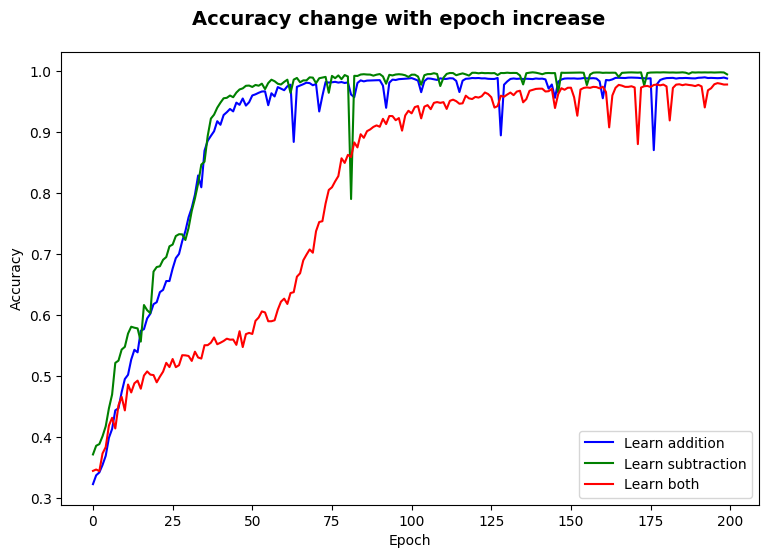

In [100]:
fig = plt.figure(figsize=(9,6),dpi=100)  
fig.suptitle('Accuracy change with epoch increase',y = 0.95, fontsize = 14, fontweight='bold')
ax = fig.add_subplot(1,1,1)
ax.plot(originList, color='b', label='Learn addition')
ax.plot(originList_sub, color='g', label='Learn subtraction')
ax.plot(originList_both, color='r', label='Learn both' )
ax.set_xlabel("Epoch")      
ax.set_ylabel("Accuracy")
ax.legend(loc=4)